# The Quantum Circuit Born Machine (QCMB) as a Market Generator
This code has been created based on the algorithm presented in chapter 9 of the book
#### Quantum Machine Learning and Optimisation in Finance by A. Jacquier and O. Kondratyev (2022, Packt Publishing)

A parametrised quantum circuit (PQC) is trained to generate synthetic data that will have a statistical distribution close to the original dataset, here chosen from finance, here daily log-returns of a stock index (German DAX). The PQC (ansatz) is trained using a genetic algorithm, instead of using a gradient based training algorithm. Starting from random sets of parameters $\theta$ ($12 \times 7$ matrices) for the PQC, these are improved by mutation, allowing one entry of each column to be altered with probability $\alpha$ in each step, where $\alpha$ decreases exponentially from generation to generation. With the trained circuit, new (synthetic) market data can be generated simply by sampling the circuit once for each new data point.

In [299]:
import numpy as np
import matplotlib.pyplot as plt

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, FreeParameter, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

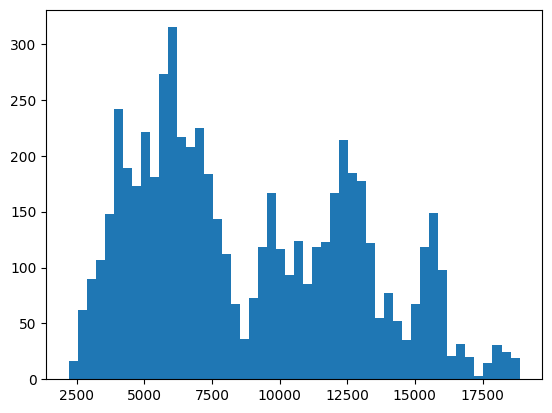

In [300]:

# load some data that we wish to synthetically generate new samples for,
# here daily log-returns of a (the German DAX) stock index
import pandas as pd


path = "../data/dax_historical_short.csv"
df = pd.read_csv(path)  # load data downloaded from the UCI Machine Learning Repository
                                                # https://archive.ics.uci.edu/ml/datasets/ISTANBUL%20STOCK%20EXCHANGE
D = df[['Date','Close']] # take daily DAX (German stock index) log-returns from the dataset for a period of 536 days

DAX_min = D['Close'].min() # maximum value of the data
DAX_max = D['Close'].max() # minimum value of the data
DAX_range = DAX_max - DAX_min   # data range

data = D['Close'].to_numpy()  # convert data to numpy array
plt.hist(data,bins=50)  # plot the data as a histogram
plt.show()

In [301]:
# function to convert data in the interval (vmin-epsilon,vmax+epsilon) into bitstring using 12-bit precision
def data_to_bitstring(value,vmin,vmax,epsilon=0,precision=12):
    int_value = int((value - vmin + epsilon)/((vmax-vmin)+2*epsilon)*(2**precision-1))
    bitstring = format(int_value,'012b')
    return bitstring

# convert bitstring of length precision to a data point in the range (vmin-epsilon,vmax+epsilon)
def bitstring_to_data(bitstring,vmin,vmax,epsilon=0):
    precision = len(bitstring)
    bitstring = bitstring[::-1]
    vint = 0
    for j in range(precision):
        vint += int(bitstring[j])*(2**j)  # obtain integer representation from the bitstring
    value = vmin - epsilon + vint/(2**precision-1)*(vmax - vmin + 2*epsilon) # bring into the range (vmin-epsilon,vmax+epsilon)
    return value

In [302]:
# get Rigetti Aspen-M3 device from AWS -- need to be registered with AWS
# device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")
# we use a simulator here for practice runs, also training the circuit could become expensive! (10e7 shots required in total)
device = LocalSimulator()

### Parametrized Quantum Circuit (Born Machine)

The ansatz for the quantum circuit used by the Born machine consists of 7 layers of 1-qubit gates with entangling layers (CNOT gates) in between. The number of wires (qubits) needed depends on the precision required for the generated data. Here, we choose 12-bit precision, the data can take $2^{12}$ different values in the range $(v_\text{min}-\epsilon,v_\text{max}+\epsilon)$, where $\epsilon > 0$ allows data to be generated that lie outside the range $(v_\text{min},v_\text{max})$ of the original data.

In [303]:
# Construct the PQC (parameterized quantum circuit) ansatz for the Quantum Circuit Born Machine (QCBM)
qcbm = Circuit()
wires = 12 # number of wires corresponding to the bit precision required for the data, here 12 bits
depth = 7  # number of parametrised 1-qubit gate layers
theta = [[FreeParameter("t_%s_%s" % (l,q)) for q in range(wires)] for l in range(depth)]
# free parameters (angles) are labelled t_i_j, where i is the layer of the circuit and j the wire

for q in range(wires):
    qcbm.rx(q,theta[0][q])  # layer of rx gates with unspecified parameters
    qcbm.rz(q,theta[1][q])  # layer of rz gates with unspecified parameters

for q in range(wires//2):       ## layer of interlinked cnot gates for entanglement
    qcbm.cnot(control=2*q,target=(2*q+1)%wires)
for q in range(wires//2):
    qcbm.cnot(control=2*q+1,target=(2*(q+1))%wires)

for q in range(wires):
    qcbm.rz(q,theta[2][q]) # layer of rx gates with unspecified parameters
    qcbm.rx(q,theta[3][q]) # layer of rz gates with unspecified parameters
    qcbm.rz(q,theta[4][q]) # layer of rx gates with unspecified parameters

for q in range(wires//2):       ## layer of interlinked cnot gates for entanglement
    qcbm.cnot(control=wires-1-2*q,target=(wires-2*q)%wires)
for q in range(wires//2):
    qcbm.cnot(control=wires-2-2*q,target=wires-1-2*q)

for q in range(wires):
    qcbm.rz(q,theta[5][q])  # layer of rz gates with unspecified parameters
    qcbm.rx(q,theta[6][q])  # layer of rx gates with unspecified parameters

print(qcbm)

T   : │      0       │      1       │  2  │     3     │      4       │      5       │      6       │     7     │  8  │      9       │      10      │
       ┌───────────┐  ┌───────────┐              ┌───┐ ┌───────────┐  ┌───────────┐  ┌───────────┐  ┌───┐             ┌───────────┐  ┌───────────┐  
q0  : ─┤ Rx(t_0_0) ├──┤ Rz(t_1_0) ├────●─────────┤ X ├─┤ Rz(t_2_0) ├──┤ Rx(t_3_0) ├──┤ Rz(t_4_0) ├──┤ X ├─────────●───┤ Rz(t_5_0) ├──┤ Rx(t_6_0) ├──
       └───────────┘  └───────────┘    │         └─┬─┘ └───────────┘  └───────────┘  └───────────┘  └─┬─┘         │   └───────────┘  └───────────┘  
       ┌───────────┐  ┌───────────┐  ┌─┴─┐         │   ┌───────────┐  ┌───────────┐  ┌───────────┐    │         ┌─┴─┐ ┌───────────┐  ┌───────────┐  
q1  : ─┤ Rx(t_0_1) ├──┤ Rz(t_1_1) ├──┤ X ├───●─────┼───┤ Rz(t_2_1) ├──┤ Rx(t_3_1) ├──┤ Rz(t_4_1) ├────┼─────●───┤ X ├─┤ Rz(t_5_1) ├──┤ Rx(t_6_1) ├──
       └───────────┘  └───────────┘  └───┘   │     │   └───────────┘  └───────────┘  └───────────┘    │   

The QCBM takes a $12 \times 7$ matrix of parameters (angles in the range $(-\pi,\pi)$ as input, in form of a dictionary. Each angle takes one of $2^m$ discrete values, where $m$ is a model parameter (here $m=7$). The resulting search space is huge: $(2^7)^{12\cdot 7} \approx 10^{177}$. This search space is explored using a genetic algorithm to avoid the common barren plateau phenomenon known in gradient based optimisation algorithms.

In [304]:
# generate random angles in the range (-pi,pi) to initialize the parameters of the QCBM
def random_thetas(m=7,dim=[12,7]):
# generate a random array of dimension 'size' each parameter can take m discrete values between -pi and +pi
    thetas = np.random.randint(2**m,size=dim)
    thetas = np.pi/2**(m-1) * thetas
    thetas -= np.pi
    return thetas

# Prepare dictionary from parameter values theta that can serve as input for the parameterized quantum circuit of the QCBM
def thetas_to_dict(thetas):
    wires, depth = thetas.shape
    theta_dict = {}
    for i in range(depth):
        for j in range(wires):
            t_str = 't_' + str(i) + '_' + str(j)
            theta_dict[t_str] = thetas[j][i]
    return theta_dict

In [305]:
def draw_data_sample(data,K=100):  # draws K samples randomly from the original data
    u = []                         # need these in the cost function to compare with the QCBM generated data below
    rows = len(data)
    for i in range(K):
        index = np.random.randint(rows)  # pick a random row index of the date array
        u.append(data[index])            # retrieve the data value at this index and append to u
    return u

### Running the QCBM

Now we can sample the QCBM circuit, represented by a unitary $U(\theta)$ with parameters $\theta$ ($12 \times 7$ matrix). Here this is done for N different sets of parameters. Samples are obtained by simply preparing the circuit, $U(\theta)$, and measuring the QCBM circuit and converting the resulting bistrings to real-valued data, one for each shot: $\langle 0 | U(\theta) | 0 \rangle$.

Each measurement gives a 12-bit string that is converted to a real valued data sample.

In [306]:
def run_qcbm(Nthetas,vmin,vmax,epsilon=0,K=100): # samples K times from the QCBM for each set of parameters in Nthetas
    Nv = []                                      # array to hold N sets of samples from K shots each
    for thetas in Nthetas:
        thetas_dict = thetas_to_dict(thetas)
        task = device.run(qcbm,shots=K,inputs=thetas_dict)   # Here the quantum circuit is executed, incurring cost
        result = task.result()                               # get results of the measurements
        counts = result.measurement_counts                   # obtain bitstrings with their respective counts
        v = []
        for bitstring, count in counts.items():
            value = bitstring_to_data(bitstring,vmin,vmax,epsilon=epsilon)  # convert bitstring to real valued data
            for i in range(count):
                v.append(value)                                             # append each data as many times as it was measured
        Nv.append(v)
    return Nv

### Cost function

The cost function is computed as the sum of squared differences of the (sorted!) data drawn from the original $u$ and the sampled data $v$ generated by the QCBM:
$$\text{cost}(u,v) = \sum_{i=1}^K (u_\text{sorted}[i] - v_\text{sorted}[i])^2$$

In [307]:
# cost function, defined as the sum of squared differences of K generated samples and samples drawn from the original data
def cost(u,v):
    K = len(u)
    u_sorted = np.sort(u)    # sort data by value
    v_sorted = np.sort(v)    # sort generated samples by value
    squared_diff_sum = 0     # compute the sum of squared differences between the sorted samples
    for i in range(K):
        squared_diff_sum += (u_sorted[i]-v_sorted[i])**2  # add the squared difference for each data / sample pair
    return squared_diff_sum  # return the sum of squared differences

### Mutation of parameters

The main step in training the QCBM is called a mutation. For each column of a $\theta$ ($12 \times 7$) matrix, one entry is modified (independently) with probability $\alpha$ to a random value, the mutation parameter. After that, with probabily $\frac{\alpha}{2}$ a second entry of each column is replaced to allow for simultaneous mutation of two column entries. From each $\theta$ matrix, $D$ copies of mutated matrices are produced. The parameter $\alpha$ will be decreased in each generation by a factor $\exp(-\beta)$, where $\beta$ is chosen so that after $50$ generations, $\alpha$ is halved.

In [308]:
# To find good parameter values by running a genetic algorithm, this function performs one mutation step
# Mutation works by creating D copies of each set of theta values in Mthetas and changing column entries with probability alpha
# return a list Nthetas of N=M*D sets of parameter values
def mutation(Mthetas,D,alpha,m=7):
    Nthetas_new = []
    for thetas in Mthetas:
        wires, depth = thetas.shape
        for d in range(D):            # for each set of theta values create D mutations, generating N = M*D mutations in total
            theta_trans = thetas.copy().transpose()  # make a copy of the current theta values which is to be mutated
            for i in range(depth):
                if np.random.rand() < alpha:                                 # with probability alpha perform a mutation
                    wire = np.random.randint(wires)                          # select a random wire
                    angle = np.random.randint(2**m)*np.pi/(2**(m-1)) - np.pi # generate a random angle in (-pi,pi) in 2**m steps
                    theta_trans[i][wire] = angle                             # replace angle in the chosen wire
                    if np.random.rand() < alpha/2:                         # perform a second mutation with probability alpha/2
                        wire = np.random.randint(wires)                          # select a random wire (could be same as above)
                        angle = np.random.randint(2**m)*np.pi/(2**(m-1)) - np.pi # generate a random angle in (-pi,pi)
                        theta_trans[i][wire] = angle                         # replace angle in the chosen wire
            Nthetas_new.append(theta_trans.transpose())                      # append mutated theta values to parameter list
    return Nthetas_new

To evaluate the quality of the parameter matrix $\theta$, the QCBM is sampled with $K=100$ shots for these parameters and compared with the same number of samples drawn from the original data by computing the cost function of the sorted samples.

In [309]:
# calculates the cost for all sets of theta values in Nthetas for the data by sampling the QCBM,
# returning the thetas sorted by cost
def thetas_by_cost(Nthetas,data,vmin,vmax,epsilon=0,K=100):
    u = draw_data_sample(data,K)                           # draw samples from the original data to compare with generated data
    Nv = run_qcbm(Nthetas,vmin,vmax,epsilon=epsilon,K=K)   # for each set of theta values, sample the QCBM K times
    cost_vector = []
    for v in Nv:                           # compute the cost function between the original data and each set of QCBM samples
        cost_vector.append(cost(u,v))
    cost_thetas = list(zip(cost_vector,Nthetas))
    cost_thetas.sort()                     # sort the list by the value of the cost function
    cost_sorted = [x for x,y in cost_thetas]
    Nthetas_sorted = [y for x,y in cost_thetas]
    return cost_sorted, Nthetas_sorted

### Genetic algorithm

Now we run a genetic algorithm for $L=100$ generations to explore the parameter space. The mutation parameters $\alpha$ and $\beta$ are chosen so that the mutation probability $\alpha$ (starting at $1.0$) is halved every $50$ generations. After generating a random family of $1000$ parameter matrices $\theta$, the best $M=25$ (according to the smallest cost) are kept and mutated, with $40$ copies each. If the minimal cost of the mutated generation decreases, the new parameters are kept and the best $25$ mutated again, and so on.

In [310]:
# Train the parameters of the QCBM ansatz using a genetic algorithm
# THIS CAN TAKE A WHILE!!!
def train(beta):
    L = 10 # number of iterations (generations) for the genetic algorithm
    M = 25  # number of best solutions in the given generation, chosen for further mutation
    D = 40  # number of 'offspring' each solution (1..M) produces through mutation
    N = D*M # number of solutions in each generation
    alpha, beta = 1.0, beta
    #alpha, beta = 1.0, 0.013863 # mutation parameters
    kappa = 50 # number of generations after which mutation rate has decreased by a factor of 1/2

    epsilon = 0.01   # amount by which generated data can lie outside the range of original data: (vmin - epsilon,vmax + epsilon)

    # initialize N sets of theta values with random angles
    Nthetas = []
    for i in range(N):
        Nthetas.append(random_thetas())

    # compute the cost for samples obtained from the QCBM and record the minimum
    cost_sorted, Nthetas_sorted = thetas_by_cost(Nthetas,data,DAX_min,DAX_max,epsilon=epsilon)
    print('Generation 0, cost = %.5f' % cost_sorted[0])
    cost_min = [cost_sorted[0]]

    # now run the genetic algorithm over L generations
    for gen in range(L):
        alpha *= np.exp(-beta)                # mutation probability alpha decreased exponentially (factor 1/2 for 50 generations)
        Mthetas = Nthetas_sorted[:M]          # keep only the best M sets of theta values
        Nthetas_new = mutation(Mthetas,D,alpha)
        cost_new, thetas_new = thetas_by_cost(Nthetas_new,data,DAX_min,DAX_max,epsilon=epsilon)
        message = 'Generation %i, cost = %.5f' % (gen+1, cost_new[0])
        if cost_new[0] < cost_min[-1]:        # if minimum cost of new parameters is less than previous minimum, keep them
            cost_min.append(cost_new[0])
            Nthetas_sorted = thetas_new
            print(message + '  improved!')    # print that parameters have improved
        else:
            print(message)
    thetas_opt = Nthetas_sorted[0]  # record the best values of theta parameters obtained from the genetic algorithm
    np.savetxt("../data/thetas_opt.csv",thetas_opt,delimiter=",")  # save good parameters to a csv file (only execute to override previous)  

In [311]:
# thetas_opt = Nthetas_sorted[0]  # record the best values of theta parameters obtained from the genetic algorithm
# np.savetxt("../data/thetas_opt.csv",thetas_opt,delimiter=",")  # save good parameters to a csv file (only execute to override previous)

Generation 0, cost = 689512715.45178
Generation 1, cost = 735722868.16686
Generation 2, cost = 581583741.26418  improved!
Generation 3, cost = 647175753.29504
Generation 4, cost = 577424496.00453  improved!
Generation 5, cost = 650176013.28109
Generation 6, cost = 821146524.11280
Generation 7, cost = 642484574.47734
Generation 8, cost = 629930655.83780
Generation 9, cost = 582623598.59999
Generation 10, cost = 718462037.26088


C:\Users\Soham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Generation 0, cost = 672839889.50215
Generation 1, cost = 684002247.81388
Generation 2, cost = 711417836.52477
Generation 3, cost = 568312679.11223  improved!
[9699.67729235 8100.57239074 8617.84228009 ... 9843.78992811 9432.1504968
 8948.5190502 ]
Generation 0, cost = 602470258.96759
Generation 1, cost = 622015098.07643
Generation 2, cost = 800590095.05412
Generation 3, cost = 498545317.97589  improved!
[ 9555.0989498  12097.51032007 11361.97987602 ... 12711.49214607
 11491.50907137  7748.8051212 ]
Generation 0, cost = 627453836.48113
Generation 1, cost = 528490147.84921  improved!
Generation 2, cost = 668177042.47805
Generation 3, cost = 762526119.38299
[10783.30834108  7678.48942108  9392.23653906 ... 10511.205424
 10732.56576873 11779.72415167]
Generation 0, cost = 834452241.43831
Generation 1, cost = 659780162.25589  improved!
Generation 2, cost = 822825487.65163
Generation 3, cost = 569143576.49410  improved!
[13853.15442927  8567.43391186  9729.67442364 ...  7485.22415339
 10340

C:\Users\Soham\AppData\Local\Temp\ipykernel_17596\4212053215.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


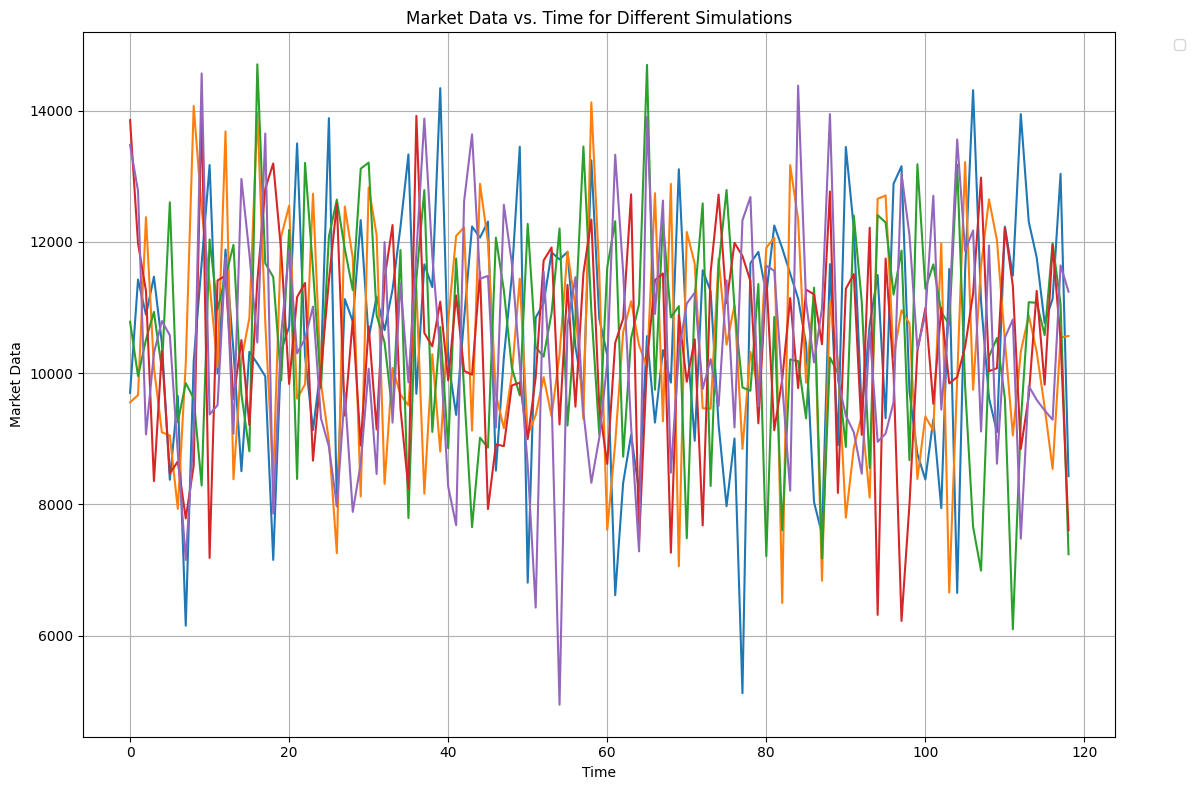

In [312]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import random


# Placeholder function for run_qcbm
def run_qcbm(thetas, DAX_min, DAX_max, epsilon=0.01, K=100):
    return [np.random.normal((DAX_max + DAX_min) / 2, (DAX_max - DAX_min) / 10, K) for _ in thetas]



# def train(beta):
#     L = 100  # number of iterations (generations) for the genetic algorithm
#     M = 25  # number of best solutions in the given generation, chosen for further mutation
#     D = 40  # number of 'offspring' each solution (1..M) produces through mutation
#     N = D*M # number of solutions in each generation
#     #alpha, beta = 1.0, 0.013863 # mutation parameters
#     alpha, beta = 1.0, beta # mutation parameters
#     kappa = 50 # number of generations after which mutation rate has decreased by a factor of 1/2

#     epsilon = 0.01   # amount by which generated data can lie outside the range of original data: (vmin - epsilon,vmax + epsilon)

#     # initialize N sets of theta values with random angles
#     Nthetas = []
#     for i in range(N):
#         Nthetas.append(random_thetas())

#     # compute the cost for samples obtained from the QCBM and record the minimum
#     cost_sorted, Nthetas_sorted = thetas_by_cost(Nthetas,data,DAX_min,DAX_max,epsilon=epsilon)
#     print('Generation 0, cost = %.5f' % cost_sorted[0])
#     cost_min = [cost_sorted[0]]

#     # now run the genetic algorithm over L generations
#     for gen in range(L):
#         alpha *= np.exp(-beta)                # mutation probability alpha decreased exponentially (factor 1/2 for 50 generations)
#         Mthetas = Nthetas_sorted[:M]          # keep only the best M sets of theta values
#         Nthetas_new = mutation(Mthetas,D,alpha)
#         cost_new, thetas_new = thetas_by_cost(Nthetas_new,data,DAX_min,DAX_max,epsilon=epsilon)
#         message = 'Generation %i, cost = %.5f' % (gen+1, cost_new[0])
#         if cost_new[0] < cost_min[-1]:        # if minimum cost of new parameters is less than previous minimum, keep them
#             cost_min.append(cost_new[0])
#             Nthetas_sorted = thetas_new
#             print(message + '  improved!')    # print that parameters have improved
#         else:
#             print(message)
#     thetas_opt = Nthetas_sorted[0]  # record the best values of theta parameters obtained from the genetic algorithm
#     np.savetxt("../data/thetas_opt.csv",thetas_opt,delimiter=",")  # save good parameters to a csv file (only execute to override previous)  
#     device = LocalSimulator()
#     samples = np.array(run_qcbm([thetas_opt], DAX_min, DAX_max, epsilon=epsilon, K=len(data))[0])
#     print(samples)
#     return samples


train(0.013863)

def train(beta):
    L = 3 # number of iterations (generations) for the genetic algorithm
    M = 25  # number of best solutions in the given generation, chosen for further mutation
    D = 40  # number of 'offspring' each solution (1..M) produces through mutation
    N = D*M # number of solutions in each generation
    alpha, beta = 1.0, beta
    #alpha, beta = 1.0, 0.013863 # mutation parameters
    kappa = 50 # number of generations after which mutation rate has decreased by a factor of 1/2

    epsilon = 0.01   # amount by which generated data can lie outside the range of original data: (vmin - epsilon,vmax + epsilon)

    # initialize N sets of theta values with random angles
    Nthetas = []
    for i in range(N):
        Nthetas.append(random_thetas())

    # compute the cost for samples obtained from the QCBM and record the minimum
    cost_sorted, Nthetas_sorted = thetas_by_cost(Nthetas,data,DAX_min,DAX_max,epsilon=epsilon)
    print('Generation 0, cost = %.5f' % cost_sorted[0])
    cost_min = [cost_sorted[0]]

    # now run the genetic algorithm over L generations
    for gen in range(L):
        alpha *= np.exp(-beta)                # mutation probability alpha decreased exponentially (factor 1/2 for 50 generations)
        Mthetas = Nthetas_sorted[:M]          # keep only the best M sets of theta values
        Nthetas_new = mutation(Mthetas,D,alpha)
        cost_new, thetas_new = thetas_by_cost(Nthetas_new,data,DAX_min,DAX_max,epsilon=epsilon)
        message = 'Generation %i, cost = %.5f' % (gen+1, cost_new[0])
        if cost_new[0] < cost_min[-1]:        # if minimum cost of new parameters is less than previous minimum, keep them
            cost_min.append(cost_new[0])
            Nthetas_sorted = thetas_new
            print(message + '  improved!')    # print that parameters have improved
        else:
            print(message)
    thetas_opt = Nthetas_sorted[0]  # record the best values of theta parameters obtained from the genetic algorithm
    np.savetxt("../data/thetas_opt.csv",thetas_opt,delimiter=",")  # save good parameters to a csv file (only execute to override previous)  
    device = LocalSimulator()
    samples = np.array(run_qcbm([thetas_opt], DAX_min, DAX_max, epsilon=epsilon, K=len(data))[0])
    print(samples)
    return samples
    

# Generate quasi-random samples using the Sobol sequence
num_samples = 5
sampler = qmc.Sobol(d=3)  # 3-dimensional Sobol sequence
samples = sampler.random(n=num_samples)

# Transform the samples to the desired ranges
iterations_samples = np.round(10 + samples[:, 0] * 90).astype(int)  # Transform to range [10, 100]
alpha_samples = 0.001 + samples[:, 1] * 0.1  # Transform to range [0.001, 0.101]
beta_samples = 0.001 + samples[:, 2] * 0.1  # Transform to range [0.001, 0.101]

# Run simulations using the Sobol sequence samples
results = []
market_data_histories = []
for beta in  beta_samples:
    market_data = train(beta)
    results.append((beta))
    market_data_histories.append(market_data)

# Plotting
plt.figure(figsize=(12, 8))

for i, market_data in enumerate(market_data_histories):
    plt.plot(market_data[::50])

plt.xlabel('Time')
plt.ylabel('Market Data')
plt.title('Market Data vs. Time for Different Simulations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Estimated value of the integral: 0.16669302812643463


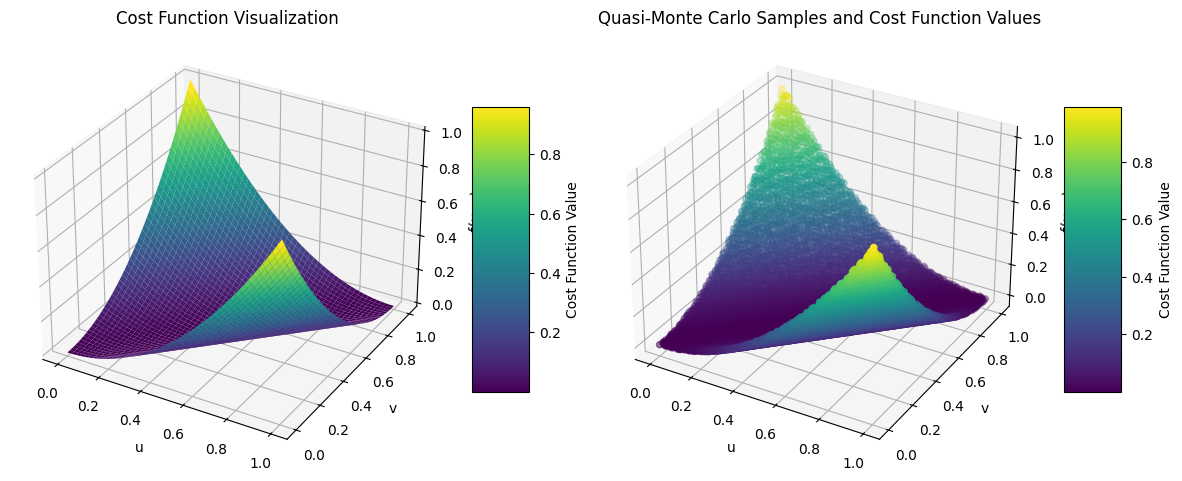

In [313]:
#Using Quasi-Monte Carlo Integration for variance reduction
# I have chosen to go for the Sobol sequence, low-discrepancy sequences
# have a faster rate of convergence
# https://link.springer.com/book/10.1007/978-0-387-78165-5

from scipy.stats import qmc


# Generate quasi-random samples using the Sobol sequence
num_samples = 10000
sampler = qmc.Sobol(d=2)  # 2-dimensional Sobol sequence
samples = sampler.random(num_samples)

# Split the samples into u and v components
u_samples = samples[:, 0]
v_samples = samples[:, 1]


function_values = np.array([cost([u], [v]) for u, v in zip(u_samples, v_samples)])
average_value = np.mean(function_values)
volume = 1 * 1
integral_estimate = average_value * volume

print(f"Estimated value of the integral: {integral_estimate}")


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')

u = np.linspace(0, 1, 50)
v = np.linspace(0, 1, 50)
u, v = np.meshgrid(u, v)
u_flat = u.flatten()
v_flat = v.flatten()


grid_function_values = np.array([cost([u_val], [v_val]) for u_val, v_val in zip(u_flat, v_flat)])
grid_function_values = grid_function_values.reshape(u.shape)

surf = ax1.plot_surface(u, v, grid_function_values, cmap='viridis')
ax1.set_xlabel('u')
ax1.set_ylabel('v')
ax1.set_zlabel('f(u, v)')
ax1.set_title('Cost Function Visualization')
cbar1 = fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
cbar1.set_label('Cost Function Value')
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(u_samples, v_samples, function_values, c=function_values, cmap='viridis')
ax2.set_xlabel('u')
ax2.set_ylabel('v')
ax2.set_zlabel('f(u, v)')
ax2.set_title('Quasi-Monte Carlo Samples and Cost Function Values')

cbar2 = fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)
cbar2.set_label('Cost Function Value')

plt.tight_layout()
plt.show()


### Using the QCBM to generate market data

Now the QCBM has been trained, we can sample from it to generate new, synthetic data that follows a statistical distribution close to the original data. To visualise this we create QQ (quantile-quantile) plots of the original data against sampled data from the QCBM.

[10366.9332053  11505.96835423  9594.81086753 ... 10432.89867731
  9668.12828513 11728.97281874]
[11728.97281874  9668.12828513 10432.89867731 ...  9594.81086753
 11505.96835423 10366.9332053 ]


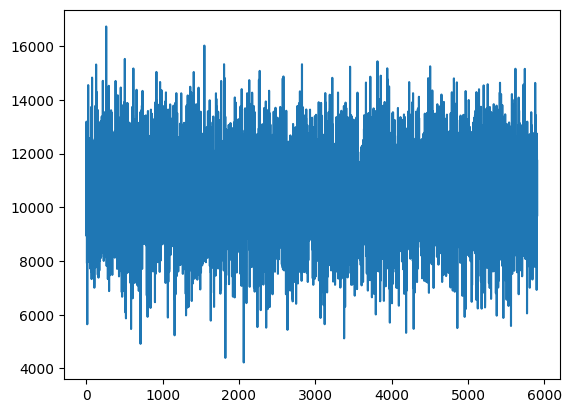

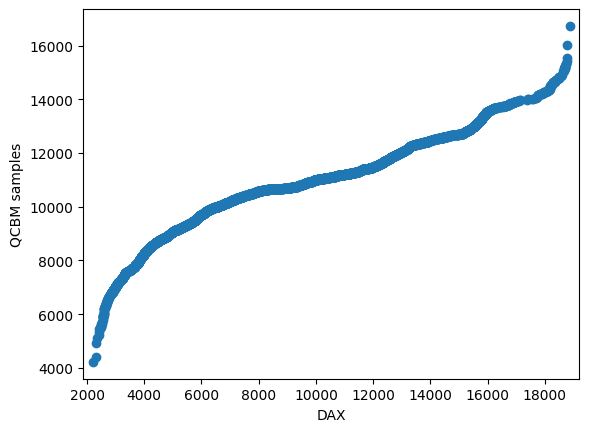

In [314]:
# create a QQ (quantile-quantile) plot of the two distributions (DAX log-returns and QCBM generated data)
# once a good set of theta parameters has been obtained and saved in "thetas_opt.csv", this section can be executed on its own

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

thetas_opt = np.genfromtxt("../data/thetas_opt.csv",delimiter=",") # load good theta parameters previously obtained to avoid
                                                         # having to run the training algorithm again
device = LocalSimulator()    # use simulator, below we will use actual quantum hardware
samples = np.array(run_qcbm([thetas_opt],DAX_min,DAX_max,epsilon=epsilon,K=len(data))[0])
print(samples)
plt.plot(samples)


print(samples[::-1])
pp_x = sm.ProbPlot(data)  # probability plot of x-data
pp_y = sm.ProbPlot(samples)  # probabilily plot of y-data
qqplot_2samples(pp_x, pp_y,xlabel='DAX',ylabel='QCBM samples')  # plot the two sets against one another
plt.show()

In [315]:
# Take the market data and add variance for back testing and stress testing purposes
# Use a monte carlo simulation on the mutation factors






The approximate diagonality of the plot indicates the similarity of the distributions of synthesized data and the original data. In this way the QCBM can be used as a generator for market data to be used e.g. in simulations.

### Running the QCBM on Rigetti quantum hardware

Now we can run the trained QCBM on actual quantum hardware, here Rigetti's Aspen-M3 device accessed via AWS.

In [316]:
from braket.tracking import Tracker  # Use Braket SDK Cost Tracking to estimate the cost to run this example
t = Tracker().start()

# use Rigetti's Aspen-M3 device
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

thetas_opt = np.genfromtxt("thetas_opt.csv",delimiter=",") # load good theta parameters previously obtained to avoid
                                                           # having to run the training algorithm again
thetas_dict = thetas_to_dict(thetas_opt)
task = device.run(qcbm,shots=len(data),inputs=thetas_dict)   # Here the quantum circuit is executed, incurring cost
rigetti_task_id = task.id
status = task.state()
print(status)

NoRegionError: You must specify a region.

In [ ]:
# retrieve samples obtained from the QCBM run on Rigetti's Aspen-M3 device and generate QQ plots against original data
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

thetas_opt = [Nthetas_sorted[0]]                 # select the best set of theta values obtained by the genetic algorithm

task_load = AwsQuantumTask(arn=rigetti_task_id)  # recover AWS task executed above
status = task_load.state()

if status == 'COMPLETED':
    print(status)
    # get results
    result = task_load.result()
    counts = result.measurement_counts                   # obtain bitstrings with their respective counts
    v = []
    for bitstring, count in counts.items():
        value = bitstring_to_data(bitstring,DAX_min,DAX_max,epsilon=epsilon)  # convert bitstring to real valued data
        for i in range(count):
            v.append(value)
    samples = np.array(v)
    pp_x = sm.ProbPlot(data)  # probability plot of x-data
    pp_y = sm.ProbPlot(samples)  # probabilily plot of y-data
    qqplot_2samples(pp_x, pp_y,xlabel='DAX',ylabel='QCBM samples')  # plot the two sets against one another
    plt.show()
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message
    print('Your task is in terminal status, but has not completed.')
else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

Sorry, your task is still being processed and has not been finalized yet.


In [ ]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 536, 'tasks': {'QUEUED': 1}}}
Estimated cost to run this example: 0.49 USD
